# ROBUST

This notebook is used to reproduce produce the figures for the paper, "ROBUST: Replicating and Understanding 208 Bugs in Robot Operating System".

In [1]:
import collections
import os
import typing as t

import IPython
import robust
import tabulate
import yaml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from robust import BugDescription, ROBUST
    
DATASET = ROBUST("..")


def table(contents: t.Sequence[t.Sequence[t.Any]]) -> None:
    """Produces a pretty table in the notebook."""
    html = IPython.display.HTML(tabulate.tabulate(con|tents, tablefmt='html'))
    IPython.display.display|(html)
    
    
def counter_to_df(counter: collections.Counter, index: str) -> pd.DataFrame:
    """Converts a counter to a Pandas DataFrame."""
    # https://stackoverflow.com/questions/31111032/transform-a-counter-object-into-a-pandas-dataframe
    df = pd.DataFrame.from_dict(counter, orient='index')
    df = df.reset_index()
    df = df.rename(columns={'index': index, 0: 'Frequency'})
    return df.set_index(index)


def normalize_language(language: str) -> str:
    """Renames a given language in the dataset for the sake of reporting."""
    renamings = {
        'srv': 'ROS IDL',
        'ROS Message': 'ROS IDL',
        '.gitattributes': 'Other',
        'Other YAML': 'Other',
        'RViz': 'Other',
        'udev rules': 'Other',
        'Shell': 'Other',
        'Xacro': 'Xacro/URDF',
        'URDF': 'Xacro/URDF', 
    }
    return renamings.get(language, language)

### What languages are involved in the fix?

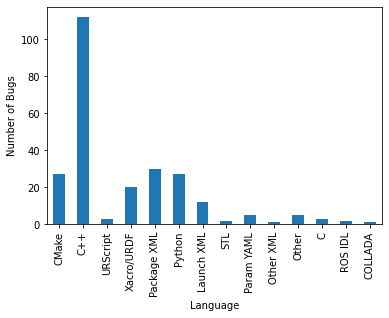

In [11]:
def language_vs_number_of_bugs() -> None:
    tally = collections.Counter()
    for bug_description in DATASET.values():
        for language in (bug_description.fix.languages or []):
            language = normalize_language(language)
            tally[language] += 1
            
    df = counter_to_df(tally, 'Language')
    df.plot(kind='bar', ylabel='Number of Bugs', legend=False)
    # print(df)
    

language_vs_number_of_bugs()

### How many fixes cover more than one language?

                     Frequency
Number of Languages           
1                          200
2                           14
3                            3
4                            1
5                            1


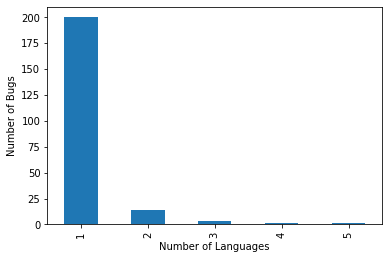

In [12]:
def number_of_languages_in_fix() -> None:
    tally = collections.Counter()
    for bug_description in DATASET.values():
        languages = set()
        for language in (bug_description.fix.languages or []):
            languages.add(normalize_language(language))
        num_languages = len(languages)
        
        # ignore bugs without a fix
        if num_languages > 0:
            tally[num_languages] += 1
            
    # put the x-axis labels in the correct order
    ordered_tally = collections.Counter()
    for num_languages in sorted(tally):
        ordered_tally[num_languages] = tally[num_languages]

    df = counter_to_df(ordered_tally, 'Number of Languages')
    df.plot(kind='bar', ylabel='Number of Bugs', legend=False)
    print(df)
    

number_of_languages_in_fix()

### How many files are modified by the fix?

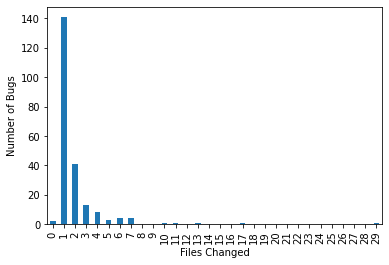

In [13]:
def num_files_fixed() -> None:
    tally = collections.Counter()
    for description in DATASET.values():
        fixed_files = description.fix.fix_in
        if fixed_files is None:
            num_fixed = 0
        else:
            num_fixed = len(fixed_files)
        tally[num_fixed] += 1
        
    max_files_changed = max(tally)
    files_changed_to_num_bugs = {n: tally[n] for n in range(max_files_changed + 1)}
        
    df = counter_to_df(files_changed_to_num_bugs, 'Files Changed')
    df.plot(kind='bar', ylabel='Number of Bugs', legend=False)
    # print(df)


num_files_fixed()

Let's find out what files are modified by the associated PR or fix commit.

### How many lines are changed by the fix? (diff lines)

skipping bug [/home/chris/bugs/robust/motoman/045ab54/045ab54.bug: missing 'fix.commits' in bug description]: BugDescription(filename='/home/chris/bugs/robust/motoman/045ab54/045ab54.bug')
skipping bug [missing stats]: BugDescription(filename='/home/chris/bugs/robust/universal_robot/1e0904c/1e0904c.bug')
skipping bug [expected commits section to be a list]: BugDescription(filename='/home/chris/bugs/robust/confidential/96e2c6c/96e2c6c.bug')
skipping bug [missing stats]: BugDescription(filename='/home/chris/bugs/robust/universal_robot/c4e1187/c4e1187.bug')
skipping bug [missing stats]: BugDescription(filename='/home/chris/bugs/robust/universal_robot/39eb24f/39eb24f.bug')
skipping bug [expected commits section to be a list]: BugDescription(filename='/home/chris/bugs/robust/confidential/86cb680/86cb680.bug')
skipping bug [missing stats]: BugDescription(filename='/home/chris/bugs/robust/geometry2/0c3aef3/0c3aef3.bug')
skipping bug [missing stats]: BugDescription(filename='/home/chris/bugs/r

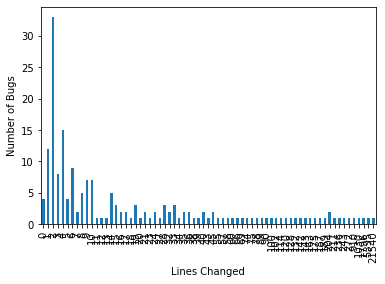

In [16]:
def num_lines_changed_by_bug(description: BugDescription) -> int:
    lines_changed = 0
    for commit in description.fix.commits:
        if commit.stats is None:
            raise ValueError('missing stats')
        lines_changed += commit.stats.total.lines
    return lines_changed
    

def num_lines_changed() -> None:
    tally = collections.Counter()
    
    for description in DATASET.values():
        try:
            lines_changed = num_lines_changed_by_bug(description)
        except ValueError as error:
            print(f"skipping bug [{error}]: {description}")
            continue
        tally[lines_changed] += 1
        
    # put x-axis labels into correct order
    ordered_tally = collections.Counter()
    for lines_changed in sorted(tally):
        ordered_tally[lines_changed] = tally[lines_changed]
        
    df = counter_to_df(ordered_tally, 'Lines Changed')
    df.plot(kind='bar', ylabel='Number of Bugs', legend=False)
        
    print(ordered_tally)
        
        
num_lines_changed()

### How often is a test case provided as part of the fix commit(s)?

In [5]:
def does_commit_include_test(commit: robust.robust.FixCommit) -> bool:
    if commit.stats is None:
        raise ValueError('missing stats')
    modified_files = set(s.filename for s in commit.stats.files)
    
    # check if file is a test file based on its name
    # this is incredibly basic, but it looks like very few commits provided tests
    for filename in modified_files:
        if 'test' in filename:
            print(filename)
    return any(True for filename in modified_files if 'test' in filename)
    

def does_fix_include_test(description: BugDescription) -> bool:
    for commit in description.fix.commits:
        if does_commit_include_test(commit):
            return True
    return False
    
    
def how_often_is_test_provided_with_fix() -> None:
    is_provided = 0
    is_not_provided = 0
    skipped = 0
    
    for description in DATASET.values():
        try:
            if does_fix_include_test(description):
                is_provided += 1
            else:
                is_not_provided += 1
        except ValueError:
            skipped += 1

    print(f"Bug fixes that provide a test case: {is_provided}")
    print(f"Bug fixes that do not provide a test case: {is_not_provided}")
    print(f"Unable to determine whether bug fix provides test case: {skipped}")
    
    
how_often_is_test_provided_with_fix()

dx100/test/utest.cpp
dx100/test/small_motion_trajectory.bag
test_tf2/test/test_static_publisher.cpp
tf2_sensor_msgs/test/test_tf2_sensor_msgs.py
mavros/test/test_sensor_orientation.cpp
kobuki_qtestsuite/src/kobuki_qtestsuite/battery_profile_frame.py
kobuki_qtestsuite/src/kobuki_qtestsuite/ui/configuration_dock.ui
kobuki_qtestsuite/scripts/kobuki_qtestsuite
kobuki_qtestsuite/setup.py
kobuki_qtestsuite/src/kobuki_qtestsuite/configuration_dock_widget.py
kobuki_qtestsuite/src/kobuki_qtestsuite/full_size_data_plot.py
kobuki_qtestsuite/src/kobuki_qtestsuite/testsuite_widget.py
tf2_geometry_msgs/scripts/test.py
tf2_geometry_msgs/test/test_python.launch
kobuki_qtestsuite/src/kobuki_qtestsuite/battery_profile_frame.py
kobuki_qtestsuite/src/kobuki_qtestsuite/gyro_drift_frame.py
libmavconn/test/test_hang.cpp
kobuki_driver/src/test/initialisation.cpp
ur_description/launch/test.launch
kobuki_qtestsuite/src/kobuki_qtestsuite/battery_profile_frame.py
kobuki_qtestsuite/src/kobuki_qtestsuite/gyro_drift